In [149]:
import os
import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder
from sklearn import model_selection

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression

from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

In [150]:
cwd = os.path.join(os.getcwd(), 'Group Coursework Brief-20221106', 'Data_Files', 'Data_Files')
dirName_trainData = os.path.join(cwd, 'epl-training.csv')

In [151]:
df_epl_train = pd.read_csv(dirName_trainData)

In [152]:
df_epl_train.head()

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,Referee,...,HST,AST,HC,AC,HF,AF,HY,AY,HR,AR
0,19/08/00,Charlton,Man City,4.0,0.0,H,2.0,0.0,H,Rob Harris,...,14.0,4.0,6.0,6.0,13.0,12.0,1.0,2.0,0.0,0.0
1,19/08/00,Chelsea,West Ham,4.0,2.0,H,1.0,0.0,H,Graham Barber,...,10.0,5.0,7.0,7.0,19.0,14.0,1.0,2.0,0.0,0.0
2,19/08/00,Coventry,Middlesbrough,1.0,3.0,A,1.0,1.0,D,Barry Knight,...,3.0,9.0,8.0,4.0,15.0,21.0,5.0,3.0,1.0,0.0
3,19/08/00,Derby,Southampton,2.0,2.0,D,1.0,2.0,A,Andy D'Urso,...,4.0,6.0,5.0,8.0,11.0,13.0,1.0,1.0,0.0,0.0
4,19/08/00,Leeds,Everton,2.0,0.0,H,2.0,0.0,H,Dermot Gallagher,...,8.0,6.0,6.0,4.0,21.0,20.0,1.0,3.0,0.0,0.0


In [153]:
# Transform the date column from strings into datetime objects
df_epl_train["Date"] = pd.to_datetime(df_epl_train["Date"], dayfirst=True)

In [154]:
df_epl_train.head()

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,Referee,...,HST,AST,HC,AC,HF,AF,HY,AY,HR,AR
0,2000-08-19,Charlton,Man City,4.0,0.0,H,2.0,0.0,H,Rob Harris,...,14.0,4.0,6.0,6.0,13.0,12.0,1.0,2.0,0.0,0.0
1,2000-08-19,Chelsea,West Ham,4.0,2.0,H,1.0,0.0,H,Graham Barber,...,10.0,5.0,7.0,7.0,19.0,14.0,1.0,2.0,0.0,0.0
2,2000-08-19,Coventry,Middlesbrough,1.0,3.0,A,1.0,1.0,D,Barry Knight,...,3.0,9.0,8.0,4.0,15.0,21.0,5.0,3.0,1.0,0.0
3,2000-08-19,Derby,Southampton,2.0,2.0,D,1.0,2.0,A,Andy D'Urso,...,4.0,6.0,5.0,8.0,11.0,13.0,1.0,1.0,0.0,0.0
4,2000-08-19,Leeds,Everton,2.0,0.0,H,2.0,0.0,H,Dermot Gallagher,...,8.0,6.0,6.0,4.0,21.0,20.0,1.0,3.0,0.0,0.0


AIM:

1) Given match date, Filter the dataframe for the all games of current year

2) Given HomeTeam & AwayTeam, Filter database for all games (in this time frame) where HomeTeam is Home against all other teams, same for AwayTeam -> Return two filtered dataframes

3) Average these past stats for the home and away teams from current and last season

4) Give the home and away teams ratings based upon the weighted sum of the past stats

5) Create a expected goals predictor using linear/polynomial regression using the past average stats

6) Final Classifier takes as input: Home and Away Team ratings, expected goals, day, month, hometeam and awayteam

In [155]:
# This function will take as input a date, HomeTeam and AwayTeam and output two filtered dataframe

def filter_dataframe(date, HomeTeam, AwayTeam):
    # Convert the input string date into datetime
    date = pd.to_datetime(date, dayfirst=True)
    
    # NOTE both dataframes are filtered to only show matches played in current season/year
    # NOTE that if a teams game is first of the season/year, there would be no current season past data, this would also be the case when we have no past data

    # Filter the dataframe to HomeTeam Games where team is at home
    df_epl_train_filtered_Home = df_epl_train.copy()
    df_epl_train_filtered_Home = df_epl_train_filtered_Home[(df_epl_train.Date<date) & (df_epl_train.Date.dt.year>=date.year-0) & (df_epl_train.HomeTeam==HomeTeam)]

    # Filter the dataframe to AwayTeam Games where team is away
    df_epl_train_filtered_Away = df_epl_train.copy()
    df_epl_train_filtered_Away = df_epl_train_filtered_Away[(df_epl_train.Date<date) & (df_epl_train.Date.dt.year>=date.year-0) & (df_epl_train.AwayTeam==AwayTeam)]
    
#     if df_epl_train_filtered_Home.shape[0] == 0:
#         df_epl_train_filtered_Home = df_epl_train.copy()
#         df_epl_train_filtered_Home = df_epl_train_filtered_Home[(df_epl_train.Date<date) & (df_epl_train.Date.dt.year>=date.year-1) & (df_epl_train.HomeTeam==HomeTeam)]
        
#     if df_epl_train_filtered_Away.shape[0] == 0:
#         df_epl_train_filtered_Away = df_epl_train.copy()
#         df_epl_train_filtered_Away = df_epl_train_filtered_Away[(df_epl_train.Date<date) & (df_epl_train.Date.dt.year>=date.year-1) & (df_epl_train.AwayTeam==AwayTeam)]
    
    # Return filtered dataframe
    return df_epl_train_filtered_Home, df_epl_train_filtered_Away


# For Example:
# date = "24/06/2020"
# HomeTeam = "Newcastle"
# AwayTeam = "Aston Villa"

# An example to see what the function does:
df_epl_train_filtered_Home, df_epl_train_filtered_Away = filter_dataframe("24/06/2020", "Newcastle", "Aston Villa")
print(df_epl_train_filtered_Home)
print(df_epl_train_filtered_Away)

           Date   HomeTeam          AwayTeam  FTHG  FTAG FTR  HTHG  HTAG HTR  \
7421 2020-01-01  Newcastle         Leicester   0.0   3.0   A   0.0   2.0   A   
7446 2020-01-18  Newcastle           Chelsea   1.0   0.0   H   0.0   0.0   D   
7464 2020-02-01  Newcastle           Norwich   0.0   0.0   D   0.0   0.0   D   
7493 2020-02-29  Newcastle           Burnley   0.0   0.0   D   0.0   0.0   D   
7516 2020-06-21  Newcastle  Sheffield United   3.0   0.0   H   0.0   0.0   D   

         Referee  ...  HST   AST    HC    AC    HF    AF   HY   AY   HR   AR  
7421  M Atkinson  ...  2.0  10.0   4.0   5.0   8.0  12.0  1.0  1.0  0.0  0.0  
7446  C Kavanagh  ...  2.0   4.0   1.0  10.0   9.0  14.0  1.0  1.0  0.0  0.0  
7464  M Atkinson  ...  5.0   4.0   8.0  12.0  10.0  15.0  2.0  1.0  0.0  0.0  
7493    A Madley  ...  4.0   1.0  11.0   7.0  11.0   9.0  4.0  3.0  0.0  0.0  
7516     D Coote  ...  8.0   1.0   2.0   4.0   9.0  10.0  2.0  0.0  0.0  1.0  

[5 rows x 22 columns]
           Date     Ho

In [156]:
# This function takes as input a filtered dataframe from previous cell, features to average and a dictionary,
# it then appends an average of each feature to the dictionary

def average_columns(features, avg_features, filtered_df):
    for feature in features:
        df_col_means = filtered_df[feature].mean()
        avg_features[feature].append(df_col_means)

In [157]:
# Run the two functions for each row of our df_epl_train dataframe to fill dictionary with AVG for each match
# NOTE: Some matches won't have past stats since its the first game of the season or we might not have past data

features = ["FTHG","FTAG","HTHG","HTAG","HS","AS","HST","AST","HF","AF","HC","AC","HY","AY","HR","AR"]
avg_features_HOME = {
                        "FTHG": [],
                        "FTAG": [],
                        "HTHG": [],
                        "HTAG": [],
                        "HS"  : [],
                        "AS"  : [],
                        "HST" : [],
                        "AST" : [],
                        "HF"  : [],
                        "AF"  : [],
                        "HC"  : [],
                        "AC"  : [],
                        "HY"  : [],
                        "AY"  : [],
                        "HR"  : [],
                        "AR"  : []
                    }

avg_features_AWAY = {
                        "FTHG": [],
                        "FTAG": [],
                        "HTHG": [],
                        "HTAG": [],
                        "HS"  : [],
                        "AS"  : [],
                        "HST" : [],
                        "AST" : [],
                        "HF"  : [],
                        "AF"  : [],
                        "HC"  : [],
                        "AC"  : [],
                        "HY"  : [],
                        "AY"  : [],
                        "HR"  : [],
                        "AR"  : []
                    }

# Run the two functions on each row of the df_epl_train and fill the dictionary
# We need to do this for the HOME filtered dataframe, and AWAY filtered dataframe

# For each row in our original dataframe
for index, row in df_epl_train.iterrows():
    # Filter the dataframe and get averages
    df_epl_train_filtered_Home, df_epl_train_filtered_Away = filter_dataframe(row["Date"],row["HomeTeam"],row["AwayTeam"])
    average_columns(features, avg_features_HOME, df_epl_train_filtered_Home)
    average_columns(features, avg_features_AWAY, df_epl_train_filtered_Away)
    
# Check this is correct
# print(avg_features_HOME)
# print(avg_features_AWAY)

In [158]:
# Add a column for each of these feature averages using the list of values from the dictionary
df_epl_train_updated = df_epl_train.copy()
features = ["FTHG","FTAG","HTHG","HTAG","HS","AS","HST","AST","HF","AF","HC","AC","HY","AY","HR","AR"]

for feature in features:
    # Get the list of averages for a certain feature from the dicitonary
    feature_vals_HOME = avg_features_HOME[feature]
    feature_vals_AWAY = avg_features_AWAY[feature]
    # Add the list of averages into the dataframe for that certain feature
    df_epl_train_updated[feature + "_AVG_Home"] = feature_vals_HOME
    df_epl_train_updated[feature + "_AVG_Away"] = feature_vals_AWAY

In [159]:
# Now this dataframe contains our original data + the average of the past stats (Home & Away) for each row
df_epl_train_updated

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,Referee,...,AC_AVG_Home,AC_AVG_Away,HY_AVG_Home,HY_AVG_Away,AY_AVG_Home,AY_AVG_Away,HR_AVG_Home,HR_AVG_Away,AR_AVG_Home,AR_AVG_Away
0,2000-08-19,Charlton,Man City,4.0,0.0,H,2.0,0.0,H,Rob Harris,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2000-08-19,Chelsea,West Ham,4.0,2.0,H,1.0,0.0,H,Graham Barber,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2000-08-19,Coventry,Middlesbrough,1.0,3.0,A,1.0,1.0,D,Barry Knight,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2000-08-19,Derby,Southampton,2.0,2.0,D,1.0,2.0,A,Andy D'Urso,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2000-08-19,Leeds,Everton,2.0,0.0,H,2.0,0.0,H,Dermot Gallagher,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8481,2022-10-29,Newcastle,Aston Villa,4.0,0.0,H,1.0,0.0,H,P Tierney,...,4.400000,5.000000,1.600000,2.562500,2.200000,2.437500,0.000000,0.0625,0.000000,0.062500
8482,2022-10-29,Fulham,Everton,0.0,0.0,D,0.0,0.0,D,J Brooks,...,5.166667,4.187500,1.833333,1.875000,0.833333,2.062500,0.166667,0.0000,0.166667,0.062500
8483,2022-10-29,Liverpool,Leeds,1.0,2.0,A,1.0,1.0,D,M Oliver,...,2.750000,4.866667,1.062500,1.666667,1.562500,2.133333,0.062500,0.2000,0.000000,0.066667
8484,2022-10-30,Arsenal,Nott'm Forest,5.0,0.0,H,1.0,0.0,H,S Hooper,...,3.333333,2.666667,1.400000,1.666667,2.066667,2.166667,0.066667,0.0000,0.133333,0.000000


In [160]:
# Now we loop through the updated dataframe and for each row average the HomeAvgStats and AwayAvgStats using 
# weights to give higher importance to some specific stats. This results in creating and adding two final columns.

features = ["FTHG","FTAG","HTHG","HTAG","HS","AS","HST","AST","HF","AF","HC","AC","HY","AY","HR","AR"]
feature_weights = {
                        "FTHG": 0,
                        "FTAG": 0,
                        "HTHG": 0,
                        "HTAG": 0,
                        "HS"  : 2,
                        "AS"  : 2,
                        "HST" : 2.5,
                        "AST" : 2.5,
                        "HF"  : 1.5,
                        "AF"  : 1.5,
                        "HC"  : 0.5,
                        "AC"  : 0.5,
                        "HY"  : 0.5,
                        "AY"  : 0.5,
                        "HR"  : 0.5,
                        "AR"  : 0.5
                    }
    
Home_Weighted_Avg = []
Away_Weighted_Avg = []

for index, row in df_epl_train_updated.iterrows():
    home_vals = []
    away_vals = []
    for feature in features:
        current_feature_HOME = feature + "_AVG_Home"
        current_feature_AWAY = feature + "_AVG_Away"
        current_val_HOME = row[current_feature_HOME]*feature_weights[feature]
        current_val_AWAY = row[current_feature_AWAY]*feature_weights[feature]
        home_vals.append(current_val_HOME)
        away_vals.append(current_val_AWAY)
    Home_Weighted_Avg.append(sum(home_vals)/len(home_vals))
    Away_Weighted_Avg.append(sum(away_vals)/len(away_vals))

df_epl_train_final = df_epl_train.copy()
df_epl_train_final["HomeTeam_Rating"] = Home_Weighted_Avg
df_epl_train_final["AwayTeam_Rating"] = Away_Weighted_Avg

# Check if its working correctly
df_epl_train_final

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,Referee,...,HC,AC,HF,AF,HY,AY,HR,AR,HomeTeam_Rating,AwayTeam_Rating
0,2000-08-19,Charlton,Man City,4.0,0.0,H,2.0,0.0,H,Rob Harris,...,6.0,6.0,13.0,12.0,1.0,2.0,0.0,0.0,NaN,NaN
1,2000-08-19,Chelsea,West Ham,4.0,2.0,H,1.0,0.0,H,Graham Barber,...,7.0,7.0,19.0,14.0,1.0,2.0,0.0,0.0,NaN,NaN
2,2000-08-19,Coventry,Middlesbrough,1.0,3.0,A,1.0,1.0,D,Barry Knight,...,8.0,4.0,15.0,21.0,5.0,3.0,1.0,0.0,NaN,NaN
3,2000-08-19,Derby,Southampton,2.0,2.0,D,1.0,2.0,A,Andy D'Urso,...,5.0,8.0,11.0,13.0,1.0,1.0,0.0,0.0,NaN,NaN
4,2000-08-19,Leeds,Everton,2.0,0.0,H,2.0,0.0,H,Dermot Gallagher,...,6.0,4.0,21.0,20.0,1.0,3.0,0.0,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8481,2022-10-29,Newcastle,Aston Villa,4.0,0.0,H,1.0,0.0,H,P Tierney,...,3.0,0.0,11.0,11.0,1.0,1.0,0.0,0.0,7.327083,7.351562
8482,2022-10-29,Fulham,Everton,0.0,0.0,D,0.0,0.0,D,J Brooks,...,13.0,4.0,10.0,8.0,2.0,1.0,0.0,0.0,6.973958,7.001953
8483,2022-10-29,Liverpool,Leeds,1.0,2.0,A,1.0,1.0,D,M Oliver,...,14.0,5.0,9.0,3.0,0.0,1.0,0.0,0.0,6.939453,7.297917
8484,2022-10-30,Arsenal,Nott'm Forest,5.0,0.0,H,1.0,0.0,H,S Hooper,...,9.0,4.0,9.0,8.0,0.0,1.0,0.0,0.0,7.172917,7.135417


In [161]:
# Turn the catergorical data into labels using same method from before
df_epl_train_final["AwayTeam_Enc"] = df_epl_train_final["AwayTeam"].astype("category").cat.codes
df_epl_train_final["HomeTeam_Enc"] = df_epl_train_final["HomeTeam"].astype("category").cat.codes

# Transform the date column into day and month columns and Add into dataframe (Extract days & months from date)
df_epl_train_final["Date"] = pd.to_datetime(df_epl_train_final["Date"])
df_epl_train_final["Day"] = df_epl_train_final["Date"].dt.day
df_epl_train_final["Month"] = df_epl_train_final["Date"].dt.month 
df_epl_train_final["Year"] = df_epl_train_final["Date"].dt.year

# Add average values from updated dataframe
df_epl_train_final["FTHG_AVG"] = df_epl_train_updated["FTHG_AVG_Home"]
df_epl_train_final["FTAG_AVG"] = df_epl_train_updated["FTAG_AVG_Away"]
df_epl_train_final["HTHG_AVG"] = df_epl_train_updated["HTHG_AVG_Home"]
df_epl_train_final["HTAG_AVG"] = df_epl_train_updated["HTAG_AVG_Away"]
df_epl_train_final["HS_AVG"] = df_epl_train_updated["HS_AVG_Home"]
df_epl_train_final["AS_AVG"] = df_epl_train_updated["AS_AVG_Away"]
df_epl_train_final["HST_AVG"] = df_epl_train_updated["HST_AVG_Home"]
df_epl_train_final["AST_AVG"] = df_epl_train_updated["AST_AVG_Away"]
df_epl_train_final["HF_AVG"] = df_epl_train_updated["HF_AVG_Home"]
df_epl_train_final["AF_AVG"] = df_epl_train_updated["AF_AVG_Away"]
df_epl_train_final["HC_AVG"] = df_epl_train_updated["HC_AVG_Home"]
df_epl_train_final["AC_AVG"] = df_epl_train_updated["AC_AVG_Away"]
df_epl_train_final["HY_AVG"] = df_epl_train_updated["HY_AVG_Home"]
df_epl_train_final["AY_AVG"] = df_epl_train_updated["AY_AVG_Away"]
df_epl_train_final["HR_AVG"] = df_epl_train_updated["HR_AVG_Home"]
df_epl_train_final["AR_AVG"] = df_epl_train_updated["AR_AVG_Away"]

# Check the final updated dataframe
df_epl_train_final

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,Referee,...,HST_AVG,AST_AVG,HF_AVG,AF_AVG,HC_AVG,AC_AVG,HY_AVG,AY_AVG,HR_AVG,AR_AVG
0,2000-08-19,Charlton,Man City,4.0,0.0,H,2.0,0.0,H,Rob Harris,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2000-08-19,Chelsea,West Ham,4.0,2.0,H,1.0,0.0,H,Graham Barber,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2000-08-19,Coventry,Middlesbrough,1.0,3.0,A,1.0,1.0,D,Barry Knight,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2000-08-19,Derby,Southampton,2.0,2.0,D,1.0,2.0,A,Andy D'Urso,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2000-08-19,Leeds,Everton,2.0,0.0,H,2.0,0.0,H,Dermot Gallagher,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8481,2022-10-29,Newcastle,Aston Villa,4.0,0.0,H,1.0,0.0,H,P Tierney,...,5.066667,4.437500,12.066667,12.4375,5.933333,5.000000,1.600000,2.437500,0.000000,0.062500
8482,2022-10-29,Fulham,Everton,0.0,0.0,D,0.0,0.0,D,J Brooks,...,4.666667,2.750000,9.666667,10.5000,4.666667,4.187500,1.833333,2.062500,0.166667,0.062500
8483,2022-10-29,Liverpool,Leeds,1.0,2.0,A,1.0,1.0,D,M Oliver,...,7.062500,3.933333,7.750000,12.4000,8.000000,4.866667,1.062500,2.133333,0.062500,0.066667
8484,2022-10-30,Arsenal,Nott'm Forest,5.0,0.0,H,1.0,0.0,H,S Hooper,...,6.600000,1.833333,10.066667,11.5000,7.000000,2.666667,1.400000,2.166667,0.066667,0.000000


In [162]:
# NOTE: We must remove the rows in the dataframe where the average values of stats/features are 'nan';
# we get these values because either its the teams first game of the season OR because we have
# not got the past stats for these matches. We cannot use the 'nan' values for the classifier training and 
# hence have to remove these rows. We can then train a classifier using this final dataframe.

# In the final model/classifier, in the case where we DO NOT have these past stats of the teams playing, 
# we need to switch back to using the OLD classifier which only took the 4 basic fetaures: day, month, 
# HomeTeam and AwayTeam.

# In the case where we DO have these past stats for the teams, we can use this model/classifier 
# and input the features like HST_AVG. We would find these by using the filter_dataframe() and 
# average_columns() functions to find them for any two specific teams playing each other on some date.

# Remove any rows with nan
df_epl_train_final = df_epl_train_final.dropna()
df_epl_train_final

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,Referee,...,HST_AVG,AST_AVG,HF_AVG,AF_AVG,HC_AVG,AC_AVG,HY_AVG,AY_AVG,HR_AVG,AR_AVG
19,2000-08-26,Arsenal,Charlton,5.0,3.0,H,1.0,2.0,A,Steve Lodge,...,12.000000,4.000000,25.000000,15.0000,10.000000,5.000000,2.000000,1.000000,1.000000,1.000000
20,2000-08-26,Bradford,Leicester,0.0,0.0,D,0.0,0.0,D,Steve Bennett,...,3.000000,2.000000,14.000000,14.0000,6.000000,5.000000,0.000000,3.000000,0.000000,0.000000
21,2000-08-26,Everton,Derby,2.0,2.0,D,2.0,0.0,H,Mike Riley,...,8.000000,5.000000,17.000000,11.0000,3.000000,6.000000,2.000000,3.000000,0.000000,0.000000
22,2000-08-26,Ipswich,Sunderland,1.0,0.0,H,0.0,0.0,D,Graham Poll,...,8.000000,4.000000,10.000000,14.0000,4.000000,3.000000,1.000000,3.000000,0.000000,0.000000
23,2000-08-26,Man City,Coventry,1.0,2.0,A,0.0,2.0,A,Andy D'Urso,...,10.000000,5.000000,24.000000,20.0000,7.000000,5.000000,3.000000,3.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8481,2022-10-29,Newcastle,Aston Villa,4.0,0.0,H,1.0,0.0,H,P Tierney,...,5.066667,4.437500,12.066667,12.4375,5.933333,5.000000,1.600000,2.437500,0.000000,0.062500
8482,2022-10-29,Fulham,Everton,0.0,0.0,D,0.0,0.0,D,J Brooks,...,4.666667,2.750000,9.666667,10.5000,4.666667,4.187500,1.833333,2.062500,0.166667,0.062500
8483,2022-10-29,Liverpool,Leeds,1.0,2.0,A,1.0,1.0,D,M Oliver,...,7.062500,3.933333,7.750000,12.4000,8.000000,4.866667,1.062500,2.133333,0.062500,0.066667
8484,2022-10-30,Arsenal,Nott'm Forest,5.0,0.0,H,1.0,0.0,H,S Hooper,...,6.600000,1.833333,10.066667,11.5000,7.000000,2.666667,1.400000,2.166667,0.066667,0.000000


In [163]:
# Try either using polynomial regression, NN or more features, the MSE is too high with linear regression and current features

# Here we aim to create a 'expected or predicted goals for a HomeTeam' feature based upon the HomeTeamRating, and also the past wins, losses and draws, our outputs will be full time goals(FTHG).
X2 = df_epl_train_final.loc[:,['Day', 'Month', 'HomeTeam_Enc', 'FTHG_AVG', 'HTHG_AVG', 'HS_AVG', 'HomeTeam_Rating']].values
y2 = df_epl_train_final.loc[:,'FTHG'].values
# Split the data for testing
X2_train, X2_test, y2_train, y2_test = model_selection.train_test_split(X2, y2, test_size=0.2, random_state=20)
# Here we use a linear regression classifier to predict the goals BUT could use a polynomial regression classifier:
# Create an empty linear regression model
LR_Model_HOME_EG = LinearRegression()
# Fit the model using training data
LR_Model_HOME_EG.fit(X2_train, y2_train)
# Make predictions using the model we have created
LR_H_predictions_test = LR_Model_HOME_EG.predict(X2_test)


# Similar idea for AwayTeam
X3 = df_epl_train_final.loc[:,['Day', 'Month', 'AwayTeam_Enc', 'FTAG_AVG', 'HTAG_AVG', 'AS_AVG', 'AwayTeam_Rating']].values
y3 = df_epl_train_final.loc[:,'FTAG'].values
# Split the data for testing
X3_train, X3_test, y3_train, y3_test = model_selection.train_test_split(X3, y3, test_size=0.2, random_state=20)
LR_Model_AWAY_EG = LinearRegression()
# Fit the model using training data
LR_Model_AWAY_EG.fit(X3_train, y3_train)
# Make predictions using the model we have created
LR_A_predictions_test = LR_Model_AWAY_EG.predict(X3_test)


# Check the mean square error(MSE) for HomeTeam Expected Goals
print(mean_squared_error(LR_H_predictions_test, y2_test))
# Check the mean square error(MSE) for AwayTeam Expected Goals
print(mean_squared_error(LR_A_predictions_test, y3_test))

1.5652199184663795
1.2685902843149646


In [164]:
# Using the two regression classfiers above, predict the number of goals that the Home and Away teams will hit for each row in the dataframe:
HomeExGoals = []
AwayExGoals = []
# For each row, predict the home and away expected goals
for index, row in df_epl_train_final.iterrows():
    X_Home_features = np.array([[row["Day"],row["Month"],row["HomeTeam_Enc"],row["FTHG_AVG"],row["HTHG_AVG"],row["HS_AVG"],row["HomeTeam_Rating"]]])
    X_Away_features = np.array([[row["Day"],row["Month"],row["AwayTeam_Enc"],row["FTAG_AVG"],row["HTAG_AVG"],row["AS_AVG"],row["AwayTeam_Rating"]]])
    # Note the prediction is a 1 by 1 vector
    ex_home_goals = LR_Model_HOME_EG.predict(X_Home_features)[0]
    ex_away_goals = LR_Model_AWAY_EG.predict(X_Away_features)[0]
    HomeExGoals.append(ex_home_goals)
    AwayExGoals.append(ex_away_goals)

# Add this data into the final dataframe
df_epl_train_final["Ex_Goals_Home"] = HomeExGoals
df_epl_train_final["Ex_Goals_Away"] = AwayExGoals

# Check the final dataframe
df_epl_train_final

/var/folders/qp/cqr59m4j0g90ckphpxxl1_c80000gn/T/ipykernel_32059/887663794.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_epl_train_final["Ex_Goals_Home"] = HomeExGoals
/var/folders/qp/cqr59m4j0g90ckphpxxl1_c80000gn/T/ipykernel_32059/887663794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_epl_train_final["Ex_Goals_Away"] = AwayExGoals


,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,Referee,...,HF_AVG,AF_AVG,HC_AVG,AC_AVG,HY_AVG,AY_AVG,HR_AVG,AR_AVG,Ex_Goals_Home,Ex_Goals_Away
19,2000-08-26,Arsenal,Charlton,5.0,3.0,H,1.0,2.0,A,Steve Lodge,...,25.000000,15.0000,10.000000,5.000000,2.000000,1.000000,1.000000,1.000000,1.666081,0.798952
20,2000-08-26,Bradford,Leicester,0.0,0.0,D,0.0,0.0,D,Steve Bennett,...,14.000000,14.0000,6.000000,5.000000,0.000000,3.000000,0.000000,0.000000,1.506293,0.641201
21,2000-08-26,Everton,Derby,2.0,2.0,D,2.0,0.0,H,Mike Riley,...,17.000000,11.0000,3.000000,6.000000,2.000000,3.000000,0.000000,0.000000,1.466520,1.266463
22,2000-08-26,Ipswich,Sunderland,1.0,0.0,H,0.0,0.0,D,Graham Poll,...,10.000000,14.0000,4.000000,3.000000,1.000000,3.000000,0.000000,0.000000,1.431297,1.068585
23,2000-08-26,Man City,Coventry,1.0,2.0,A,0.0,2.0,A,Andy D'Urso,...,24.000000,20.0000,7.000000,5.000000,3.000000,3.000000,0.000000,0.000000,1.944559,1.035216
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8481,2022-10-29,Newcastle,Aston Villa,4.0,0.0,H,1.0,0.0,H,P Tierney,...,12.066667,12.4375,5.933333,5.000000,1.600000,2.437500,0.000000,0.062500,1.608332,1.323405
8482,2022-10-29,Fulham,Everton,0.0,0.0,D,0.0,0.0,D,J Brooks,...,9.666667,10.5000,4.666667,4.187500,1.833333,2.062500,0.166667,0.062500,1.590150,1.117629
8483,2022-10-29,Liverpool,Leeds,1.0,2.0,A,1.0,1.0,D,M Oliver,...,7.750000,12.4000,8.000000,4.866667,1.062500,2.133333,0.062500,0.066667,2.340981,1.309918
8484,2022-10-30,Arsenal,Nott'm Forest,5.0,0.0,H,1.0,0.0,H,S Hooper,...,10.066667,11.5000,7.000000,2.666667,1.400000,2.166667,0.066667,0.000000,2.114188,0.846649


In [165]:
# Create the input features matrix X
# Create the output values y vector (made of FTR)
# Take these values from the transformed dataframe

# Different OPTIONS for features to use in the design matrix:

# OPTION 1 - features are Day, Month, Home/Away Team, Current/Past Season Goal Averages, HomeTeam Rating, AwayTeam Rating
# X = df_epl_train_final.loc[:,['Day', 'Month', 'HomeTeam_Enc', 'AwayTeam_Enc', 'FTHG_AVG', 'FTAG_AVG', 'HTHG_AVG', 'HTAG_AVG', 'HomeTeam_Rating' ,'AwayTeam_Rating']].values

# OPTION 2 - Same as OPTION 1 but also adds expected goals for each team
# X = df_epl_train_final.loc[:,['Day', 'Month', 'HomeTeam_Enc', 'AwayTeam_Enc', 'FTHG_AVG', 'FTAG_AVG', 'HTHG_AVG', 'HTAG_AVG', 'HomeTeam_Rating' ,'AwayTeam_Rating', 'Ex_Goals_Home', 'Ex_Goals_Away']].values

# OPTION 3 - All Features
# X = df_epl_train_final.loc[:,['Day', 'Month', 'HomeTeam_Enc', 'AwayTeam_Enc','FTHG_AVG','FTAG_AVG','HTHG_AVG','HTAG_AVG','HS_AVG','AS_AVG','HST_AVG','AST_AVG','HF_AVG','AF_AVG','HC_AVG','AC_AVG','HY_AVG','AY_AVG','HR_AVG','AR_AVG','HomeTeam_Rating','AwayTeam_Rating','Ex_Goals_Home','Ex_Goals_Away']].values

# OPTION 4 - OPTION 3 without Yellow & Red Cards
X = df_epl_train_final.loc[:,['Day', 'Month','HomeTeam_Enc', 'AwayTeam_Enc','FTHG_AVG','FTAG_AVG','HTHG_AVG','HTAG_AVG','HS_AVG','AS_AVG','HST_AVG','AST_AVG','HF_AVG','AF_AVG','HC_AVG','AC_AVG','HomeTeam_Rating','AwayTeam_Rating','Ex_Goals_Home','Ex_Goals_Away']].values

# The output value
y = df_epl_train_final.loc[:,'FTR'].values

# Split the training data in a 80-20 split
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state=22)

# Encode the y output values as well
FTR_encoder = LabelEncoder()
y_train = FTR_encoder.fit_transform(y_train);

In [166]:
# Create an empty Tree model
DT_Model = DecisionTreeClassifier(random_state=42)
# Fit the model using training data
DT_Model.fit(X_train, y_train)
# Make predictions using the model we have created
DT_predictions_test = DT_Model.predict(X_test)
# Reconverting prediction values (i.e. 0, 1 or 2) back into (H, D or A) using the FTR_encoder defined in earlier cell
DT_predictions_test = FTR_encoder.inverse_transform(DT_predictions_test)

print(accuracy_score(DT_predictions_test, y_test))
print(classification_report(DT_predictions_test, y_test))

0.40587109125717935
              precision    recall  f1-score   support

           A       0.38      0.37      0.37       475
           D       0.28      0.24      0.26       425
           H       0.49      0.54      0.51       667

    accuracy                           0.41      1567
   macro avg       0.38      0.38      0.38      1567
weighted avg       0.40      0.41      0.40      1567



In [167]:
# Create an empty KNN model
KNN_Model = KNeighborsClassifier(n_neighbors=50)
# Fit the model using training data
KNN_Model.fit(X_train, y_train)
# Make predictions using the model we have created
KNN_predictions_test = KNN_Model.predict(X_test)
KNN_predictions_test = FTR_encoder.inverse_transform(KNN_predictions_test)

print(accuracy_score(KNN_predictions_test, y_test))
print(classification_report(KNN_predictions_test, y_test))

0.5130823229100191
              precision    recall  f1-score   support

           A       0.38      0.48      0.42       359
           D       0.03      0.19      0.05        58
           H       0.84      0.54      0.66      1150

    accuracy                           0.51      1567
   macro avg       0.42      0.40      0.38      1567
weighted avg       0.71      0.51      0.58      1567



In [168]:
# Create an empty Random Forest model
RF_Model = RandomForestClassifier(n_estimators=200, random_state=42)
# Fit the model using training data
RF_Model.fit(X_train, y_train)
# Make predictions using the model we have created
RF_predictions_test = RF_Model.predict(X_test)
RF_predictions_test = FTR_encoder.inverse_transform(RF_predictions_test)

print(accuracy_score(RF_predictions_test, y_test))
print(classification_report(RF_predictions_test, y_test))

0.5239310784939375
              precision    recall  f1-score   support

           A       0.42      0.50      0.46       384
           D       0.05      0.22      0.09        90
           H       0.83      0.56      0.67      1093

    accuracy                           0.52      1567
   macro avg       0.43      0.43      0.40      1567
weighted avg       0.68      0.52      0.58      1567



/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Functi

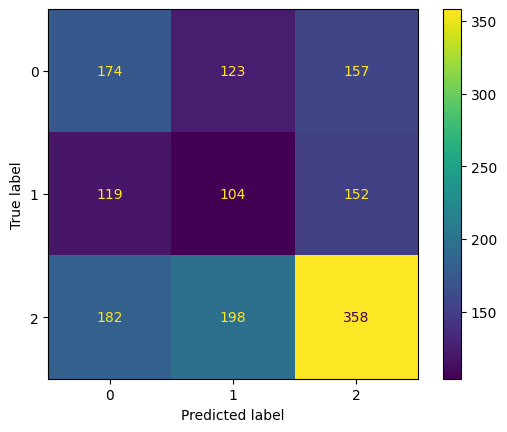

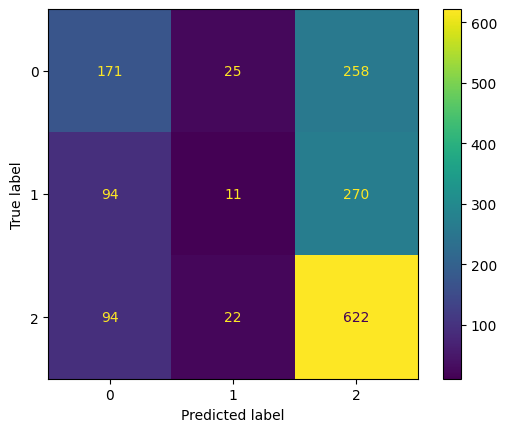

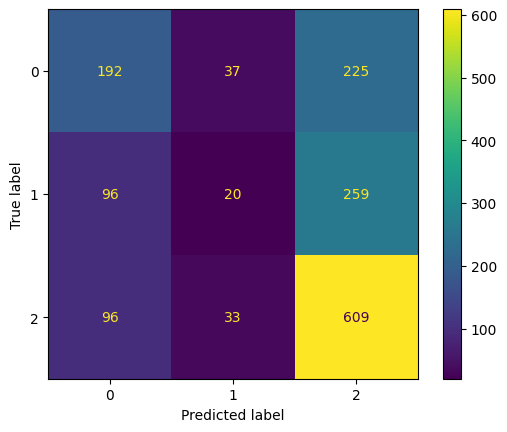

In [169]:
FTR_encoder = LabelEncoder()
y_test = FTR_encoder.fit_transform(y_test);
plot_confusion_matrix(DT_Model, X_test, y_test)
plot_confusion_matrix(KNN_Model, X_test, y_test)
plot_confusion_matrix(RF_Model, X_test, y_test)